# PART I: Tweets from Twitter 

For each movie, make a tagword using the movie name. Then, search Twitter using that tagword to download related tweets for that movie. Do the same for each movie. Clean the tweets, and then calculate the sentiment score for each tweet for each movie. Calculate the average sentiment score for each movie and save the average as the sentiment score for that movie.

## Setting up the Tagwords

In [2]:
# Import the libraries
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None

# Import u.item file to dataframe df
# Including movie title only, and removing the (year) from each row
df = pd.read_csv('u.item', sep='|', header=None)
df.drop(df.columns.difference([1]), 1, inplace=True)
df[2] = df[1]
df.columns = ['title','tag']
df['tag'] = df['tag'].str.replace(' ', '') # remove space
df['tag'] = df['tag'].str.replace(r"\(.*\)","") # remove (year)
print("Original dataset count:", df.shape[0])

############################################################################
## Observation: there are some Movie titles in this file with odd format 
## like: "Birdcage,The" and "Time to Kill, A"
## These items need to be corrected before we create tagwords

# 1 - First let's create a subset of these rows
the = df[df['tag'].astype(str).str.endswith(",The")]
a = df[df['tag'].astype(str).str.endswith(",A")]
an = df[df['tag'].astype(str).str.endswith(",An")]
df_inc = pd.concat([the, a, an])
print("Rows with incorrect movie title format: ",df_inc.shape[0])

# 2 - Then, let's drop them from the main dataset
df = df[~df['tag'].astype(str).str.contains(",The|,A|,An")]
print("Rows with correct movie title format: ",df.shape[0])

# 3 - Now, lets fix the format of these rows
print("...Fixing the incorrect movie titles")
def fix(tbl, txt):
    tbl['tag'] = f'{txt}' + tbl['tag'].astype(str) # add "The" prefix
    tbl['tag'] = tbl['tag'].replace(f',{txt}$', '', regex=True) # remove "The" suffix
    
fix(the, 'The')
fix(a, 'A')
fix(an, 'An')

# 4 - And add to the main dataset, removing comma and adding hashtag to each words
df = pd.concat([df, the, a, an], ignore_index=True, sort=False)
df['tag'] = df['tag'].str.replace(',', '') # remove comma
# df['tag'] = '#' + df['tag'].astype(str) # add hashtag prefix to all words

print("\nNew fixed dataset: ", df.shape[0])
print("Now, we can extract the tweets!")
df.sample(10)

Original dataset count: 1682
Rows with incorrect movie title format:  364
Rows with correct movie title format:  1318
...Fixing the incorrect movie titles

New fixed dataset:  1682
Now, we can extract the tweets!


,title,tag
1160,Reckless (1995),Reckless
1150,Last Summer in the Hamptons (1995),LastSummerintheHamptons
117,Monty Python's Life of Brian (1979),MontyPython'sLifeofBrian
1455,"Grifters, The (1990)",TheGrifters
424,Species (1995),Species
844,Carried Away (1996),CarriedAway
328,William Shakespeare's Romeo and Juliet (1996),WilliamShakespeare'sRomeoandJuliet
667,Amityville: Dollhouse (1996),Amityville:Dollhouse
1357,"Princess Bride, The (1987)",ThePrincessBride
1027,Carmen Miranda: Bananas Is My Business (1994),CarmenMiranda:BananasIsMyBusiness


## Extracting Tweets

In [5]:
# Import Libraries
import tweepy as tw
import pandas as pd
import progressbar as pb
pd.set_option("display.max_colwidth", 500)

# Set twitter access tokens
# Variables that contain the user credential to access twitter API
ACCESS_TOKEN = '63028258-sfWi3GbV9kVbFTje59NLnora6YvSK1FTrmLUk37bU'
ACCESS_TOKEN_SECRET = 'OjL2Na5t8w5GyFMq9mDOgsNevk8Fk2CtzAceDTfTBgkVc'
CONSUMER_API_KEY = 'ERjOpYAdSDcN1I5HMlxbWOX3V'
CONSUMER_API_SECRET = 'Iug3KHEUkAT88dF5OaiWBDxSdvqKt1V2gO4FzaXhpRpHHce1tV'

# Create an authentication object
auth = tw.OAuthHandler(CONSUMER_API_KEY, CONSUMER_API_SECRET)
auth.set_access_token(ACCESS_TOKEN,ACCESS_TOKEN_SECRET)
api = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# Collect tweets, filter RTs and limit each movie titles to max 5 tweets only
df_tweets = pd.DataFrame(columns=['tag', 'tweets'])
for i in pb.progressbar(range(len(df))):
    tweets = []
    query = df['tag'].values[i]
    result = tw.Cursor(api.search, tweet_mode="extended", q=(f'{query} -filter:retweets'),
                       full_text = True, lang="en").items(5)
    
    tweets.extend(result)
    for item in tweets:
        df_tweets = df_tweets.append({'tag': query, 'tweets': item.full_text}, ignore_index=True) 
        
# Save to csv
df_tweets.to_csv("tweets.csv")

 17% (122 of 681) |###                   | Elapsed Time: 0:00:48 ETA:   0:03:53Rate limit reached. Sleeping for: 308
 40% (278 of 681) |########              | Elapsed Time: 0:06:55 ETA:   0:02:52Rate limit reached. Sleeping for: 845
 61% (420 of 681) |#############         | Elapsed Time: 0:22:07 ETA:   0:02:05Rate limit reached. Sleeping for: 839
 82% (559 of 681) |##################    | Elapsed Time: 0:37:06 ETA:   0:00:36Rate limit reached. Sleeping for: 846
100% (681 of 681) |######################| Elapsed Time: 0:52:02 Time:  0:52:02


## Data Cleaning

In [3]:
# Import libraries
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
pd.set_option("display.max_colwidth", 500)

# load the extracted data to pd dataframe
df_tweets = pd.read_csv('tweets.csv', index_col=0)
print("Rows of extracted tweets: ", df_tweets.shape[0])

# Remove duplicates
df_tweets.drop_duplicates(subset='tweets',inplace=True)

# Function for dropping na values
def drop_na(col):
    df_tweets.dropna(inplace=True)
    df_tweets.drop(df_tweets[df_tweets[col] == ''].index, inplace=True)
    df_tweets.reset_index(drop=True, inplace=True)
    
# Remove non-alpha numeric characters, links, stopwords, lemmatize each words, drop duplicates & null values
drop_na('tweets')
stop = set().union(stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()
df_tweets['clean_txt'] = df_tweets['tweets'].str.lower()\
                        .apply(lambda x: re.split('https:\/\/.*', str(x))[0])\
                        .str.replace(r'[^a-zA-Z ]\s?',r' ',regex=True)\
                        .apply(lambda words: ' '.join(word for word in words.split() if word not in stop))\
                        .apply(lambda words: ' '.join(lemmatizer.lemmatize(word) for word in words.split()))
drop_na('clean_txt')

print("Rows of cleaned tweets: ", df_tweets.shape[0])
print("\nTable with cleaned tweets:")
df_tweets.sample(5)

Rows of extracted tweets:  5053
Rows of cleaned tweets:  4919

Table with cleaned tweets:


,tag,tweets,clean_txt
3916,Hush,10:43am Hush by The Marias from Cinema https://t.co/07DqEpHPqB,hush maria cinema
1866,BadMoon,@OrksOf @YAlpharius As it zoggin' should 'ave went.,orksof yalpharius zoggin ave went
2352,VegasVacation,"Watch the #video \n\nhttps://t.co/uT5vefbViR \nLeave a comment, LIKE, SHARE, TAG a friend.\n\n#WarGames: #Tank riding / shooting an #M9 #Flamethrower #LasVegas\n\n#guns #firearms #vegas #lasvegasstrip #sincity #love #vegasstrip #travel #vegasvacation #weapon #military #pewpew #outside https://t.co/PBwc8vlakW",watch video
2631,Fear,"We all have anticipatory nerves before social events, but those with social #anxiety have persistent fear before, during and after - no matter how big or small the event is. I chatted to @drivetimerte about #socialanxiety on Monday. Catch up here ➡️ https://t.co/OxniD9t4Gz",anticipatory nerve social event social anxiety persistent fear matter big small event chatted drivetimerte socialanxiety monday catch
1368,WingsofDesire,"✨ Opera Atelier 2021/2022: Wings of Desire ✨\n.\nIn case you missed our thrilling 21/22 Season Announcement, you can catch up on all of the exciting OA news in today's print edition of The Globe and Mail and online here: https://t.co/s8Z0oKaP1t\n.\n#OperaAtelier #WingsOfDesire #Art",opera atelier wing desire case missed thrilling season announcement catch exciting oa news today print edition globe mail online


## Sentiment Analysis - Vader

In [4]:
# Import vader sentiment intensity analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
import numpy as np

# Initialize the column
df_tweets['score'] = 0.0000

# Calculate the vader sentiment & score
print("Rows of cleaned tweets: ", df_tweets.shape[0])
for i in range(len(df_tweets)):
    rating = analyzer.polarity_scores(df_tweets['clean_txt'][i])
    df_tweets['score'][i] = rating['compound']
    
# Create new subset from df and df_tweets to map movie titles
movie_sents = (df.merge(df_tweets, left_on='tag', right_on='tag').reindex(columns=['title', 'tag', 'score']))

# Aggregate the average score for each movie
movie_sents = movie_sents.groupby(['title']).agg(['mean'])
print("Aggregated mean row count:", len(movie_sents) )
#movie_sents.to_csv("movie_score.csv")

movie_sents.sample(10)

Rows of cleaned tweets:  4919
Aggregated mean row count: 1182


,score
,mean
title,
Blink (1994),0.131940
Amityville: Dollhouse (1996),0.237633
Herbie Rides Again (1974),0.000000
Black Beauty (1994),-0.138160
Arsenic and Old Lace (1944),0.737300
Willy Wonka and the Chocolate Factory (1971),0.277840
Guantanamera (1994),0.091200
"Three Musketeers, The (1993)",0.274500


#### Visualization

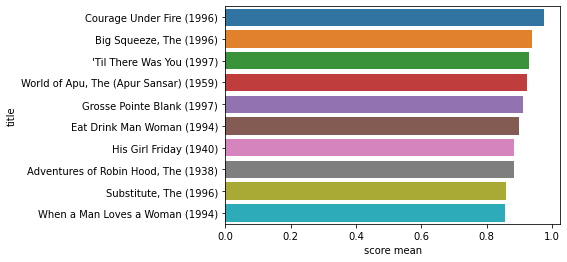

,title,score mean
268,Courage Under Fire (1996),0.97500
138,"Big Squeeze, The (1996)",0.93710
0,'Til There Was You (1997),0.93000
1174,"World of Apu, The (Apur Sansar) (1959)",0.92310
471,Grosse Pointe Blank (1997),0.91180
340,Eat Drink Man Woman (1994),0.89790
507,His Girl Friday (1940),0.88340
16,"Adventures of Robin Hood, The (1938)",0.88165
1016,"Substitute, The (1996)",0.85740
1151,When a Man Loves a Woman (1994),0.85550


In [5]:
# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt

score = pd.read_csv("movie_score.csv", header=0)
top_10 = score.sort_values(by='score mean', ascending=False)[:10]
sns.barplot(x='score mean', y='title', data=top_10)

plt.show()
top_10

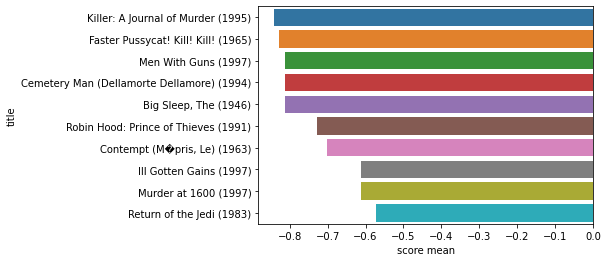

,title,score mean
589,Killer: A Journal of Murder (1995),-0.84020
372,Faster Pussycat! Kill! Kill! (1965),-0.82710
680,Men With Guns (1997),-0.81260
221,Cemetery Man (Dellamorte Dellamore) (1994),-0.81260
137,"Big Sleep, The (1946)",-0.81098
887,Robin Hood: Prince of Thieves (1991),-0.72690
260,"Contempt (M�pris, Le) (1963)",-0.70138
534,Ill Gotten Gains (1997),-0.61240
720,Murder at 1600 (1997),-0.61240
877,Return of the Jedi (1983),-0.57268


In [6]:
bottom_10 = score.sort_values(by='score mean', ascending=True)[:10]
sns.barplot(x='score mean', y='title', data=bottom_10)

plt.show()
bottom_10 

#### Mapping scores with the original dataset

Despite several attempts to extract all the tweets, we were only able to fetch valid and non-null tweets for 1182 movies out of 1682 original list. Hence, movies with missing tweets (a total of 500 movies) will have 0 sentiment score value as advised.

In [39]:
# Create new column (sentiment score) on the df dataset and map the values from score table.
mapping = dict(score[['title', 'score mean']].values)
df['sentiment_score'] = df['title'].map(mapping)
df['sentiment_score'] = df['sentiment_score'].fillna(0)
null = df['sentiment_score'].isnull().values.sum()

df.to_csv("final_df_score.csv")
print("Final dataset count: ", df.shape[0])
print("Rows with null values:", null)

df.head()

Final dataset count:  1682
Rows with null values: 0


,title,tag,sentiment_score
0,Toy Story (1995),ToyStory,0.43382
1,GoldenEye (1995),GoldenEye,-0.17804
2,Four Rooms (1995),FourRooms,0.00000
3,Get Shorty (1995),GetShorty,0.65950
4,Copycat (1995),Copycat,0.17978
